In [73]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv('flight.csv')
df.sample(5)

MEMBER_NO   FFP_DATE FIRST_FLIGHT_DATE  GENDER  FFP_TIER  WORK_CITY  \
26943      50590  5/24/2011         5/24/2011  Female         4  guangzhou   
38252       2788  6/23/2008         6/29/2013  Female         4   shenzhen   
1671       47336   8/7/2005          8/7/2005    Male         6  guangzhou   
56176      11397  4/18/2007         9/11/2007    Male         4    beijing   
631        31799  10/6/2010         10/6/2010  Female         5      75003   

      WORK_PROVINCE WORK_COUNTRY   AGE  LOAD_TIME  ...  SUM_YR_2  SEG_KM_SUM  \
26943     guangdong           CN  34.0  3/31/2014  ...    3215.0       13717   
38252     guangdong           CN  54.0  3/31/2014  ...    5111.0        6717   
1671      guangdong           CN  55.0  3/31/2014  ...   26654.0       62887   
56176       beijing           CN  38.0  3/31/2014  ...    1188.0        2029   
631           PARIS           FR  41.0  3/31/2014  ...   30150.0       91224   

       LAST_FLIGHT_DATE  LAST_TO_END  AVG_INTERVAL MAX_INTERVAL  \
26943         1/13/2014           79        38.375          171   
38252         10/5/2013          179        24.500           49   
1671          3/23/2014            9        17.525           94   
56176          3/6/2014           26       204.500          276   
631           1/23/2014           69        66.125          200   

       EXCHANGE_COUNT  avg_discount  Points_Sum  Point_NotFlight  
26943               0      0.631788        7224                0  
38252               0      0.751365        3887                0  
1671                4      0.902099       53396                5  
56176               0      0.906028        1902                0  
631                 0      0.917778       92059                0  

[5 rows x 23 columns]

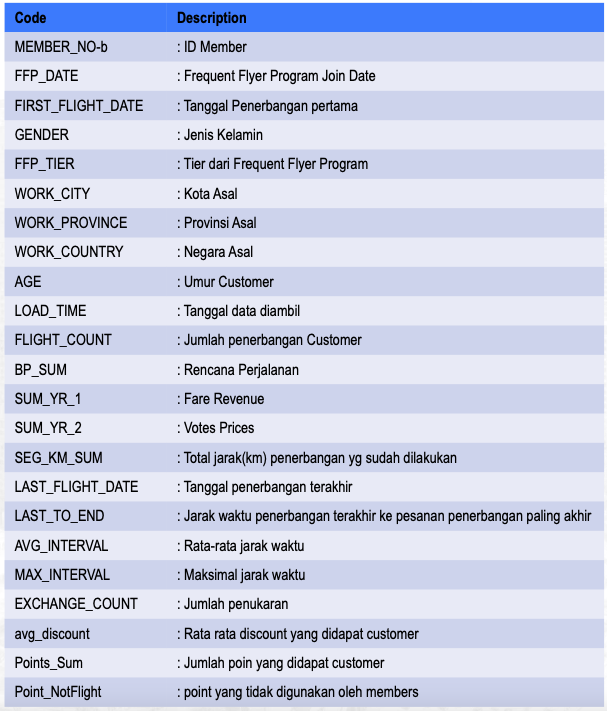

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MEMBER_NO          62988 non-null  int64  
 1   FFP_DATE           62988 non-null  object 
 2   FIRST_FLIGHT_DATE  62988 non-null  object 
 3   GENDER             62985 non-null  object 
 4   FFP_TIER           62988 non-null  int64  
 5   WORK_CITY          60719 non-null  object 
 6   WORK_PROVINCE      59740 non-null  object 
 7   WORK_COUNTRY       62962 non-null  object 
 8   AGE                62568 non-null  float64
 9   LOAD_TIME          62988 non-null  object 
 10  FLIGHT_COUNT       62988 non-null  int64  
 11  BP_SUM             62988 non-null  int64  
 12  SUM_YR_1           62437 non-null  float64
 13  SUM_YR_2           62850 non-null  float64
 14  SEG_KM_SUM         62988 non-null  int64  
 15  LAST_FLIGHT_DATE   62988 non-null  object 
 16  LAST_TO_END        629

Dari informasi data type:

  - Untuk kolom FFP_DATE, FIRST_FLIGHT_DATE, LOAD_TIME, LAST_FLIGHT_DATE lebih baik diganti datetime karena merupakan data tanggal
- Untuk kolom AGE lebih ideal menggunakan tipe data int64


- Dataframe memiliki total 62.988 baris dan 23 kolom.
- Missing values terlihat di kolom GENDER, WORK_CITY, WORK_PROVINCE, WORK_COUNTRY, AGE, SUM_YR_1,SUM_YR_2


# Seperate categorical and numerical column

In [5]:
#Numeric
numeric = df.loc[ :, (df.dtypes == int) | (df.dtypes == float)].columns.tolist()
numeric

['MEMBER_NO',
 'FFP_TIER',
 'AGE',
 'FLIGHT_COUNT',
 'BP_SUM',
 'SUM_YR_1',
 'SUM_YR_2',
 'SEG_KM_SUM',
 'LAST_TO_END',
 'AVG_INTERVAL',
 'MAX_INTERVAL',
 'EXCHANGE_COUNT',
 'avg_discount',
 'Points_Sum',
 'Point_NotFlight']

In [7]:
#Categorical
categorical = df.loc[:, (df.dtypes !=int) & (df.dtypes !=float)].columns.tolist()
categorical

['FFP_DATE',
 'FIRST_FLIGHT_DATE',
 'GENDER',
 'WORK_CITY',
 'WORK_PROVINCE',
 'WORK_COUNTRY',
 'LOAD_TIME',
 'LAST_FLIGHT_DATE']

In [9]:
df[numeric].describe().apply(lambda x:x.apply('{0:5f}'.format))

MEMBER_NO      FFP_TIER           AGE  FLIGHT_COUNT         BP_SUM  \
count  62988.000000  62988.000000  62568.000000  62988.000000   62988.000000   
mean   31494.500000      4.102162     42.476346     11.839414   10925.081254   
std    18183.213715      0.373856      9.885915     14.049471   16339.486151   
min        1.000000      4.000000      6.000000      2.000000       0.000000   
25%    15747.750000      4.000000     35.000000      3.000000    2518.000000   
50%    31494.500000      4.000000     41.000000      7.000000    5700.000000   
75%    47241.250000      4.000000     48.000000     15.000000   12831.000000   
max    62988.000000      6.000000    110.000000    213.000000  505308.000000   

            SUM_YR_1       SUM_YR_2     SEG_KM_SUM   LAST_TO_END  \
count   62437.000000   62850.000000   62988.000000  62988.000000   
mean     5355.376064    5604.026014   17123.878691    176.120102   
std      8109.450147    8703.364247   20960.844623    183.822223   
min         0.000000       0.000000     368.000000      1.000000   
25%      1003.000000     780.000000    4747.000000     29.000000   
50%      2800.000000    2773.000000    9994.000000    108.000000   
75%      6574.000000    6845.750000   21271.250000    268.000000   
max    239560.000000  234188.000000  580717.000000    731.000000   

       AVG_INTERVAL  MAX_INTERVAL EXCHANGE_COUNT  avg_discount     Points_Sum  \
count  62988.000000  62988.000000   62988.000000  62988.000000   62988.000000   
mean      67.749788    166.033895       0.319775      0.721558   12545.777100   
std       77.517866    123.397180       1.136004      0.185427   20507.816700   
min        0.000000      0.000000       0.000000      0.000000       0.000000   
25%       23.370370     79.000000       0.000000      0.611997    2775.000000   
50%       44.666667    143.000000       0.000000      0.711856    6328.500000   
75%       82.000000    228.000000       0.000000      0.809476   14302.500000   
max      728.000000    728.000000      46.000000      1.500000  985572.000000   

      Point_NotFlight  
count    62988.000000  
mean         2.728155  
std          7.364164  
min          0.000000  
25%          0.000000  
50%          0.000000  
75%          1.000000  
max        140.000000

In [10]:
df[categorical].describe()

FFP_DATE FIRST_FLIGHT_DATE GENDER  WORK_CITY WORK_PROVINCE  \
count       62988             62988  62985      60719         59740   
unique       3068              3406      2       3234          1165   
top     1/13/2011         2/16/2013   Male  guangzhou     guangdong   
freq          184                96  48134       9386         17509   

       WORK_COUNTRY  LOAD_TIME LAST_FLIGHT_DATE  
count         62962      62988            62988  
unique          118          1              731  
top              CN  3/31/2014        3/31/2014  
freq          57748      62988              959

# Data Pre-Processing (1)

In [12]:
df_clean = df.copy()

In [16]:
data_missing_value = df_clean.isnull().sum().reset_index()
data_missing_value.columns = ['feature','missing_value']
data_missing_value['percentage'] = round((data_missing_value['missing_value']/len(df_clean))*100,3)
data_missing_value = data_missing_value.sort_values('percentage', ascending=False).reset_index(drop=True)
data_missing_value = data_missing_value[data_missing_value['percentage']>0]
data_missing_value

feature  missing_value  percentage
0  WORK_PROVINCE           3248       5.157
1      WORK_CITY           2269       3.602
2       SUM_YR_1            551       0.875
3            AGE            420       0.667
4       SUM_YR_2            138       0.219
5   WORK_COUNTRY             26       0.041
6         GENDER              3       0.005

In [19]:
col_missing_value = data_missing_value['feature'].tolist() 
df_clean[col_missing_value].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   WORK_PROVINCE  59740 non-null  object 
 1   WORK_CITY      60719 non-null  object 
 2   SUM_YR_1       62437 non-null  float64
 3   AGE            62568 non-null  float64
 4   SUM_YR_2       62850 non-null  float64
 5   WORK_COUNTRY   62962 non-null  object 
 6   GENDER         62985 non-null  object 
dtypes: float64(3), object(4)
memory usage: 3.4+ MB


# Handle Missing Value

In [20]:
missing_col = ['SUM_YR_1', 'AGE', 'SUM_YR_2', 'WORK_COUNTRY', 'GENDER']
for col in missing_col:
  df_clean.dropna(subset=[col], inplace=True)

#pake mode value

In [23]:
df_clean['WORK_CITY'].fillna(df_clean['WORK_CITY'].mode()[0], inplace=True)
df_clean['WORK_PROVINCE'].fillna(df_clean['WORK_PROVINCE'].mode()[0], inplace=True)

In [24]:
data_missing_value = df_clean.isnull().sum().reset_index()
data_missing_value.columns = ['feature','missing_value']
data_missing_value

feature  missing_value
0           MEMBER_NO              0
1            FFP_DATE              0
2   FIRST_FLIGHT_DATE              0
3              GENDER              0
4            FFP_TIER              0
5           WORK_CITY              0
6       WORK_PROVINCE              0
7        WORK_COUNTRY              0
8                 AGE              0
9           LOAD_TIME              0
10       FLIGHT_COUNT              0
11             BP_SUM              0
12           SUM_YR_1              0
13           SUM_YR_2              0
14         SEG_KM_SUM              0
15   LAST_FLIGHT_DATE              0
16        LAST_TO_END              0
17       AVG_INTERVAL              0
18       MAX_INTERVAL              0
19     EXCHANGE_COUNT              0
20       avg_discount              0
21         Points_Sum              0
22    Point_NotFlight              0

oke aman

# Adjust data type

In [29]:
df_clean['AGE'] = df_clean['AGE'].astype(int) 

In [30]:
date_col = ['FFP_DATE', 'FIRST_FLIGHT_DATE', 'LOAD_TIME','LAST_FLIGHT_DATE']
for col in date_col:
  df_clean[col] = pd.to_datetime(df_clean[col])

ParserError: day is out of range for month: 2014/2/29  0:00:00

In [34]:
# Ada yg value nya ga sesuai untuk column DATE (2014/2/29), jadi kita drop
df_clean[df_clean.LAST_FLIGHT_DATE.str.contains('2014/2/29')]

Empty DataFrame
Columns: [MEMBER_NO, FFP_DATE, FIRST_FLIGHT_DATE, GENDER, FFP_TIER, WORK_CITY, WORK_PROVINCE, WORK_COUNTRY, AGE, LOAD_TIME, FLIGHT_COUNT, BP_SUM, SUM_YR_1, SUM_YR_2, SEG_KM_SUM, LAST_FLIGHT_DATE, LAST_TO_END, AVG_INTERVAL, MAX_INTERVAL, EXCHANGE_COUNT, avg_discount, Points_Sum, Point_NotFlight]
Index: []

[0 rows x 23 columns]

In [35]:
df_clean.drop(df_clean[df_clean.LAST_FLIGHT_DATE.str.contains('2014/2/29')].index, inplace = True)

In [36]:
# coba adjust lagi
date_col = ['FFP_DATE', 'FIRST_FLIGHT_DATE', 'LOAD_TIME','LAST_FLIGHT_DATE']
for col in date_col:
  df_clean[col] = pd.to_datetime(df_clean[col])

In [37]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61437 entries, 0 to 62986
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   MEMBER_NO          61437 non-null  int64         
 1   FFP_DATE           61437 non-null  datetime64[ns]
 2   FIRST_FLIGHT_DATE  61437 non-null  datetime64[ns]
 3   GENDER             61437 non-null  object        
 4   FFP_TIER           61437 non-null  int64         
 5   WORK_CITY          61437 non-null  object        
 6   WORK_PROVINCE      61437 non-null  object        
 7   WORK_COUNTRY       61437 non-null  object        
 8   AGE                61437 non-null  int64         
 9   LOAD_TIME          61437 non-null  datetime64[ns]
 10  FLIGHT_COUNT       61437 non-null  int64         
 11  BP_SUM             61437 non-null  int64         
 12  SUM_YR_1           61437 non-null  float64       
 13  SUM_YR_2           61437 non-null  float64       
 14  SEG_KM

# Feature Engineering

- Membership duration (in months)

bisa pake kolom LOAD_TIME sama FFP_DATE untuk melihat membership duration, jadi bisa tau mana pelanggan lama dan mana pelanggan baru

In [38]:
df_clean['MEMBER_DURATION'] = ((df_clean['LOAD_TIME'] - df_clean['FFP_DATE'])/np.timedelta64(1, 'M'))
df_clean['MEMBER_DURATION'] = df_clean['MEMBER_DURATION'].astype(int)

In [39]:
df_clean.sample(2)

MEMBER_NO   FFP_DATE FIRST_FLIGHT_DATE GENDER  FFP_TIER    WORK_CITY  \
12653      19759 2011-11-14        2012-09-27   Male         4  Carson City   
22333      53632 2006-03-24        2006-03-25   Male         4      baoding   

      WORK_PROVINCE WORK_COUNTRY  AGE  LOAD_TIME  ...  SEG_KM_SUM  \
12653     guangdong           US   77 2014-03-31  ...       24464   
22333         hebei           CN   51 2014-03-31  ...       12368   

       LAST_FLIGHT_DATE  LAST_TO_END  AVG_INTERVAL  MAX_INTERVAL  \
12653        2013-01-13          444    108.000000           108   
22333        2013-12-08          115     30.833333            99   

      EXCHANGE_COUNT  avg_discount  Points_Sum  Point_NotFlight  \
12653              0      0.750000        9304                0   
22333              0      0.881224       14299                6   

       MEMBER_DURATION  
12653               28  
22333               96  

[2 rows x 24 columns]

In [40]:
print('Total Row', df_clean.shape[0], ', Total Feature', df_clean.shape[1],'\n')

Total Row 61437 , Total Feature 24 



In [41]:
#Numeric
numeric = df_clean.loc[:, (df_clean.dtypes == int) | (df_clean.dtypes == float)].columns.tolist()
numeric

['MEMBER_NO',
 'FFP_TIER',
 'AGE',
 'FLIGHT_COUNT',
 'BP_SUM',
 'SUM_YR_1',
 'SUM_YR_2',
 'SEG_KM_SUM',
 'LAST_TO_END',
 'AVG_INTERVAL',
 'MAX_INTERVAL',
 'EXCHANGE_COUNT',
 'avg_discount',
 'Points_Sum',
 'Point_NotFlight',
 'MEMBER_DURATION']

# EDA

- Univariate

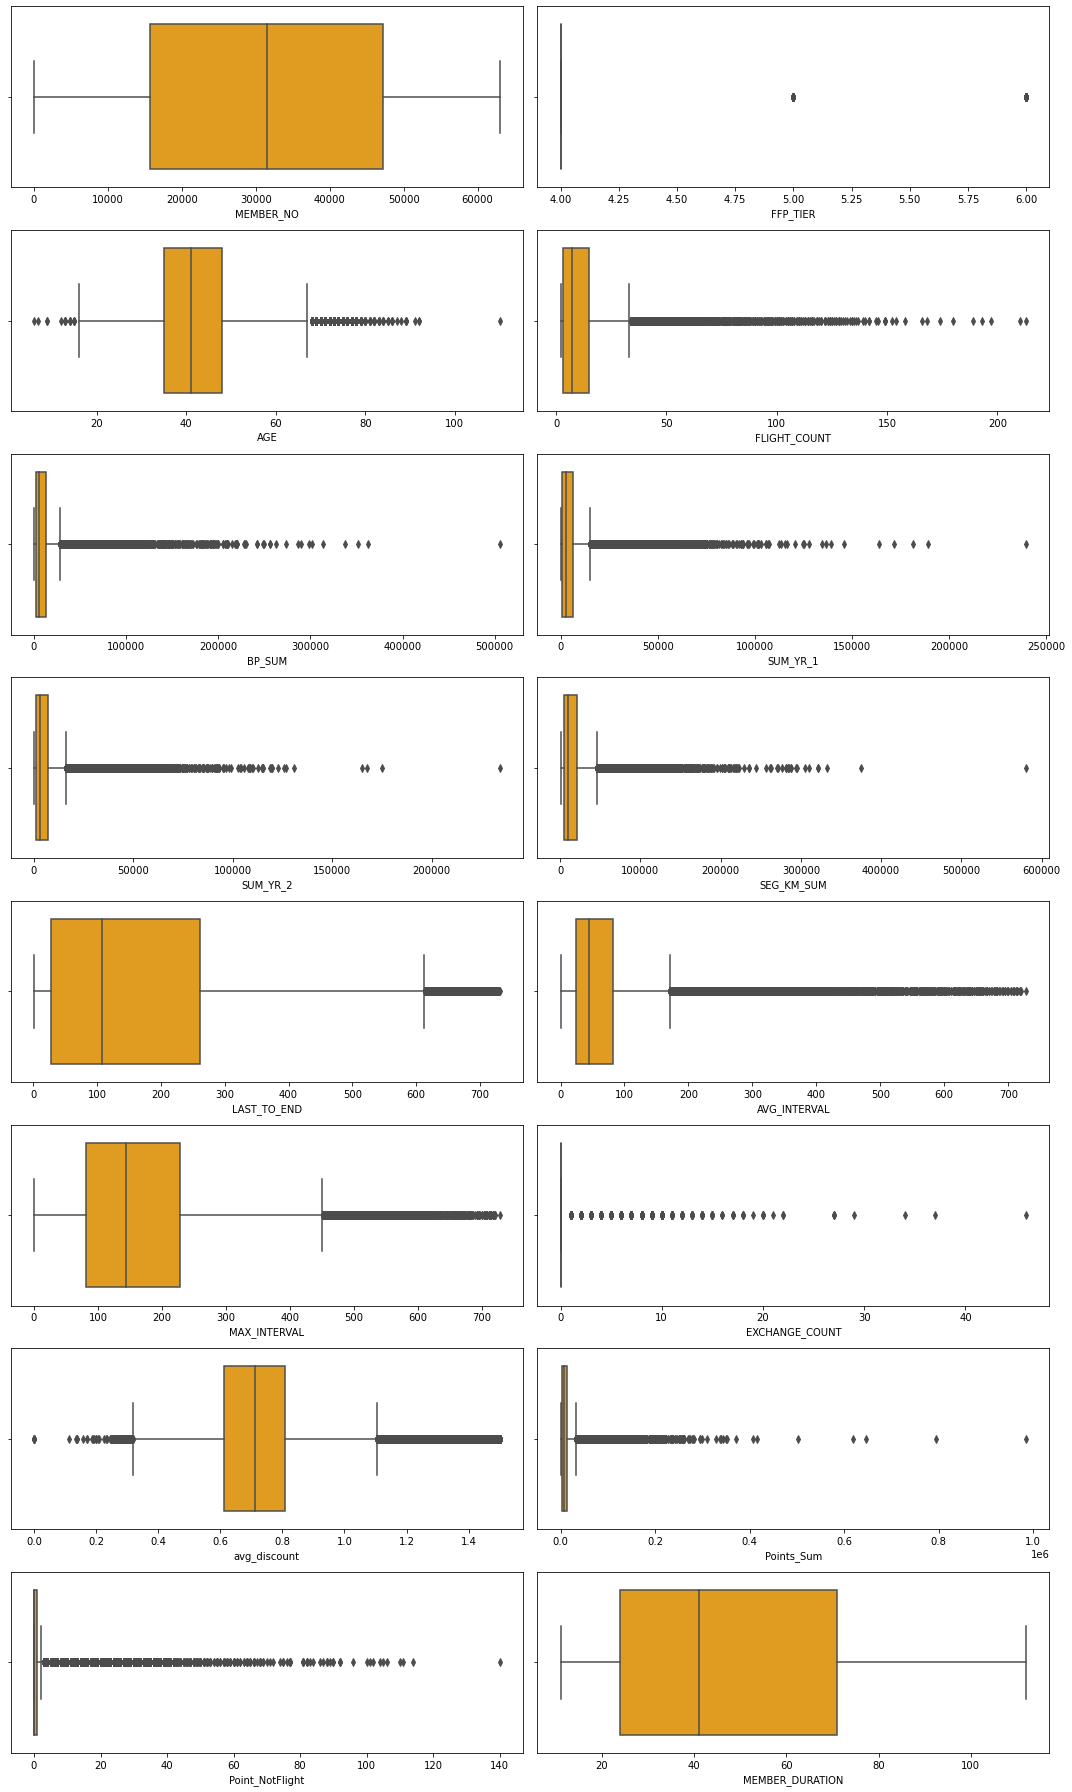

In [42]:
# boxplot visualization for numerical data

plt.figure(figsize=(15, 25))
for i in range(0, len(numeric)):
    plt.subplot(8, 2, i+1)
    sns.boxplot(x=df_clean[numeric[i]], color='orange')
    plt.tight_layout()

plt.show()

The majority of the columns have outliers, except for the MEMBER_NO, FFP_TIER and MEMBER_DURATION columns

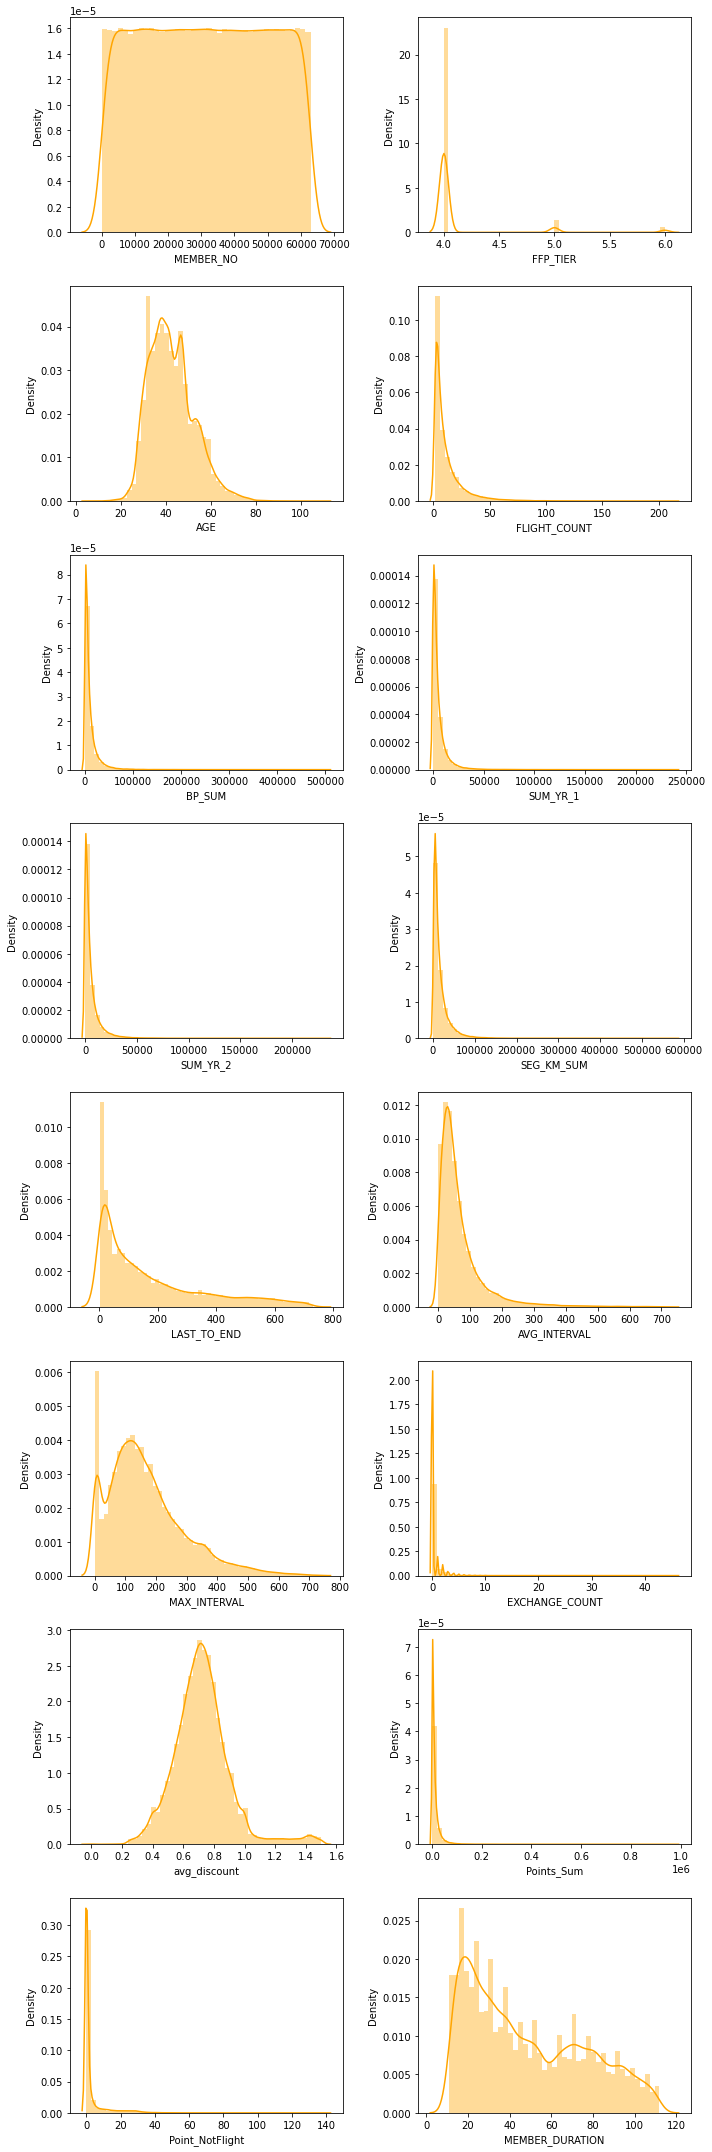

In [43]:
# distribution plot for numerical data

plt.figure(figsize=(10, 30))
for i in range(0, len(numeric)):
    plt.subplot(8, 2,i+1)
    sns.distplot(df_clean[numeric[i]], color='orange')
    plt.tight_layout()

The majority of columns appear to have a positive skewed distribution, except for the MEMBER_NO, FFP_TIER and avg_discount columns

- Multivariate

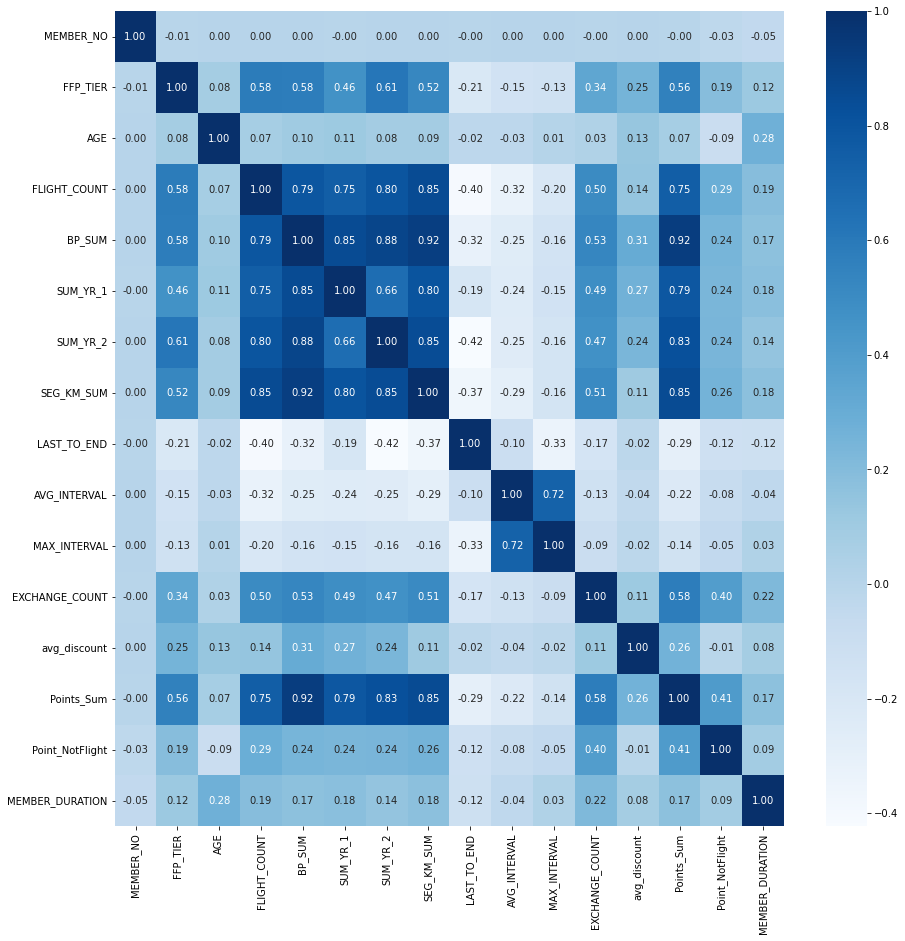

In [44]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_clean.corr(), cmap='Blues', annot=True, fmt='.2f')
plt.show()

Hampir semua feature punya korelasi positif yang tinggi (>0.5)

<Figure size 1080x1080 with 0 Axes>

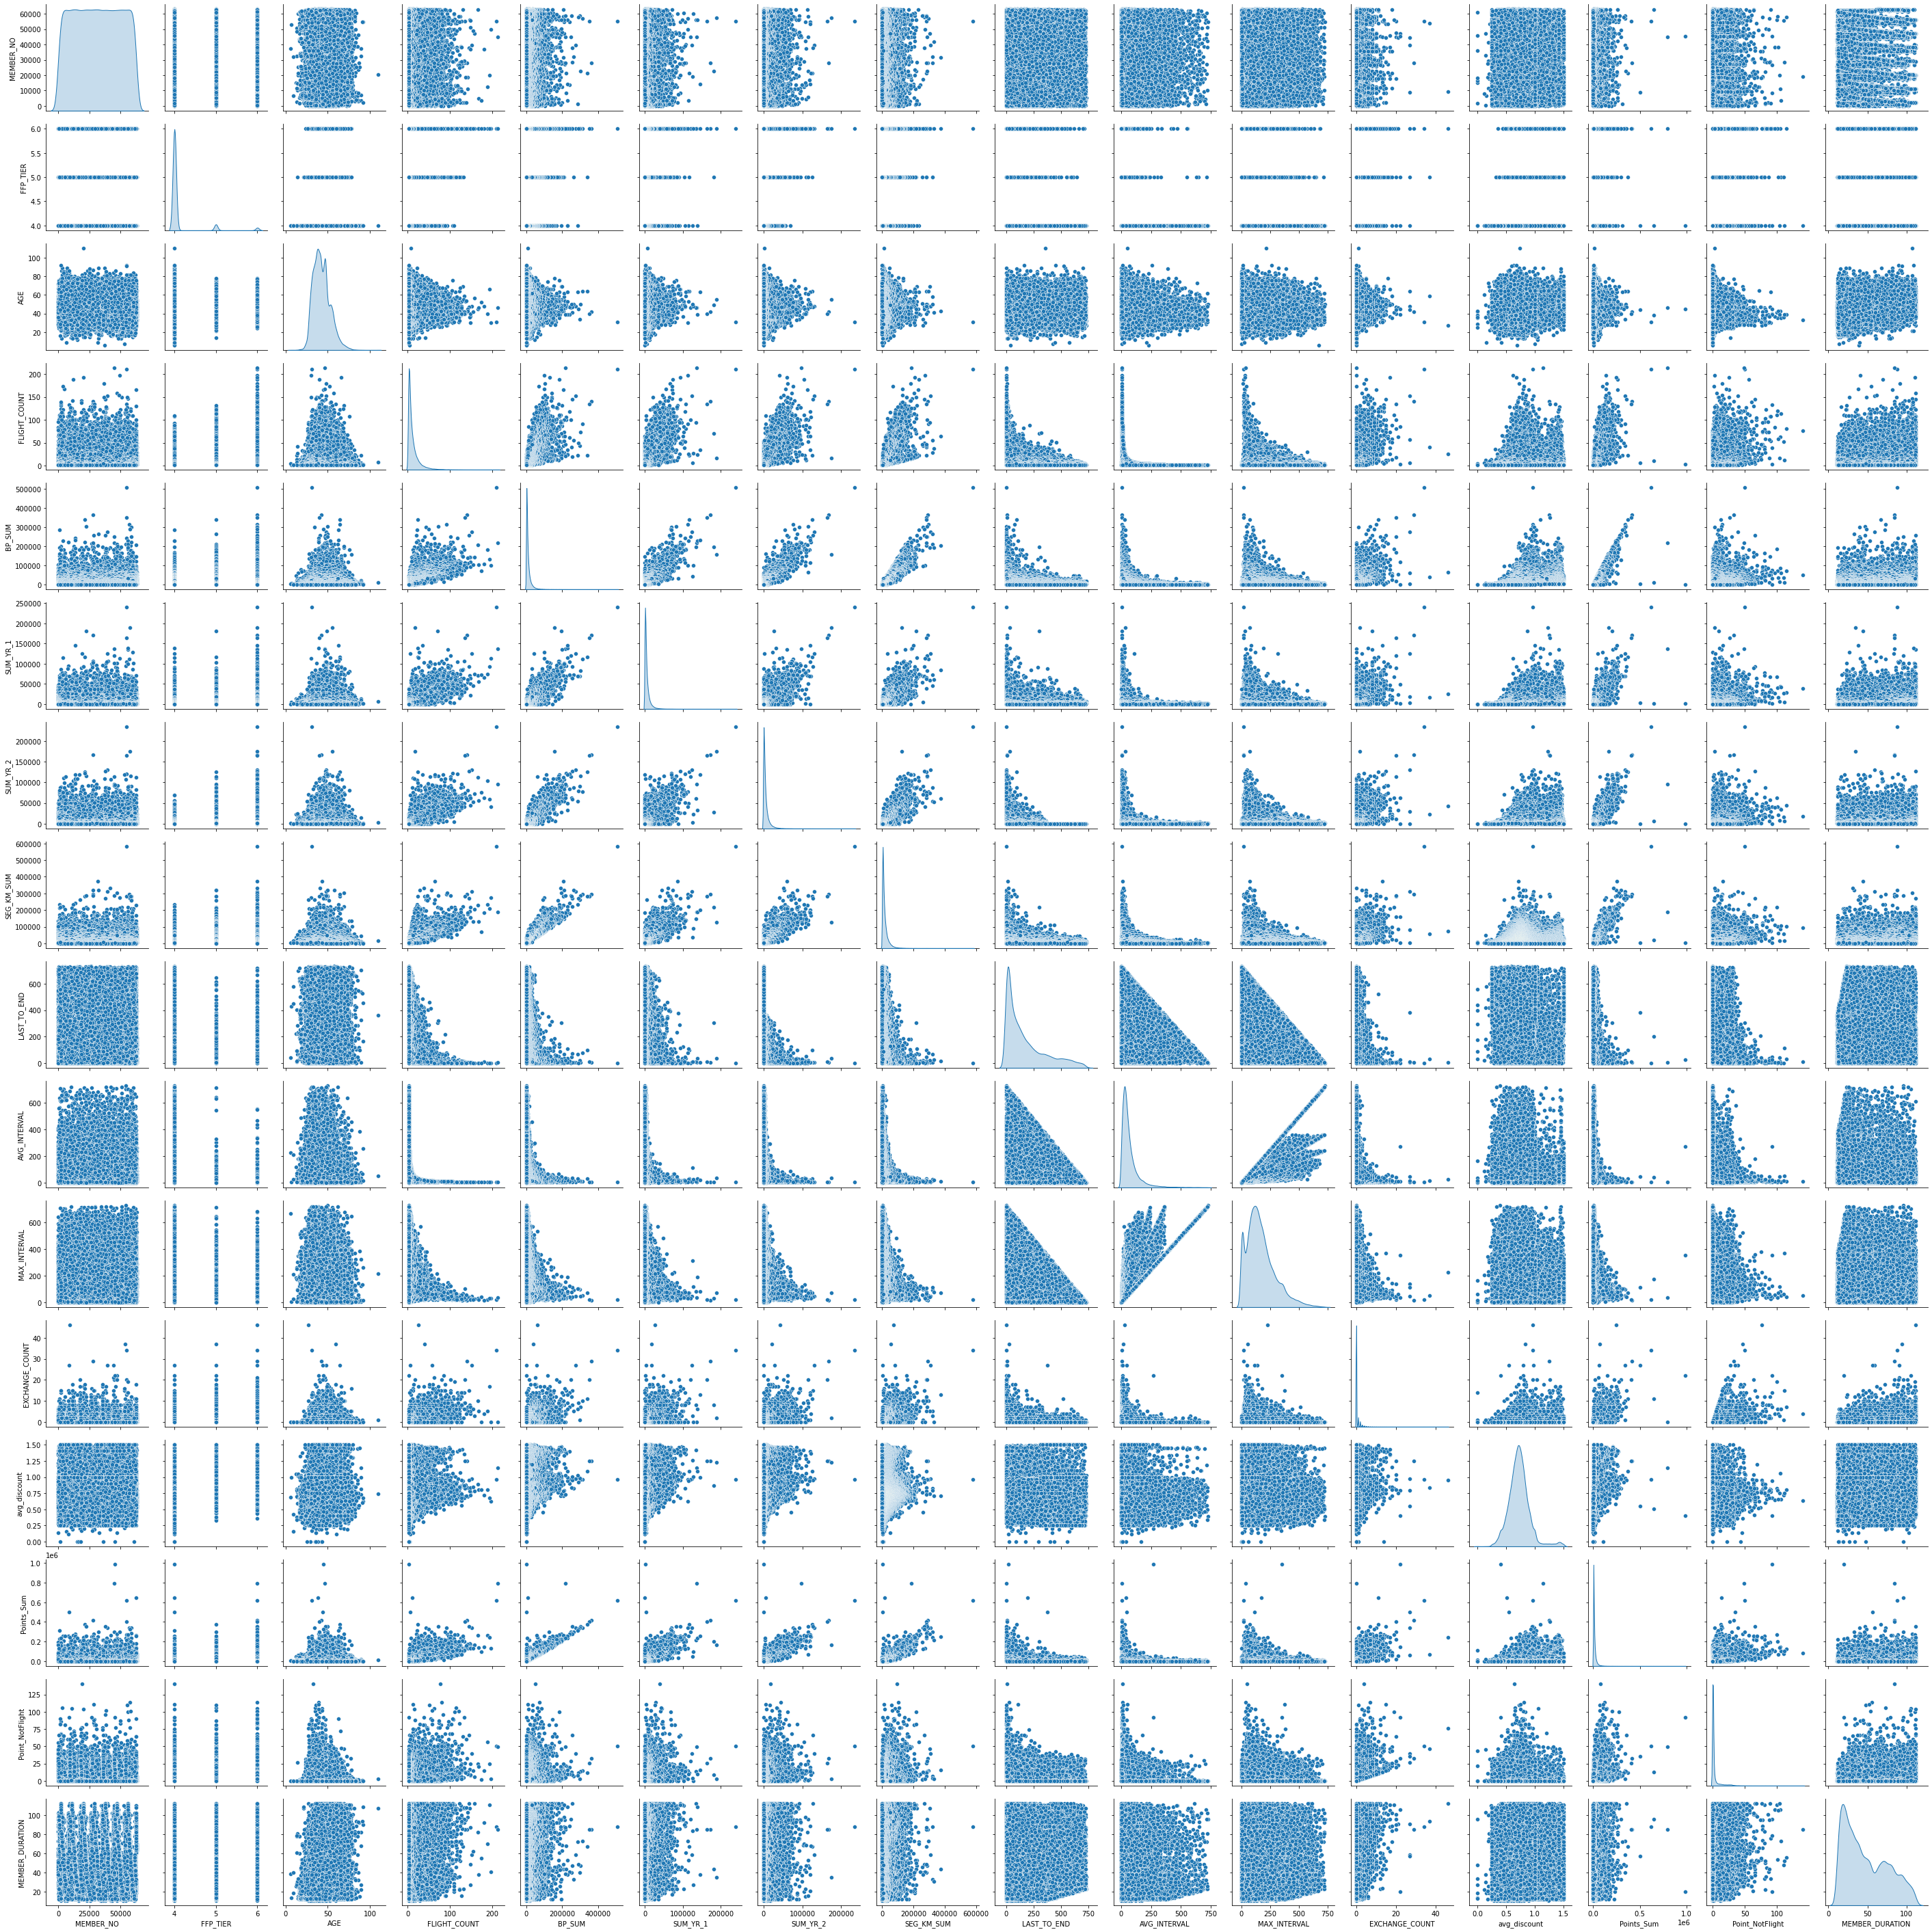

In [45]:
plt.figure(figsize=(15, 15))
sns.pairplot(df_clean, diag_kind='kde')
plt.show()

ga keliatan apa-apa jd kita based on heatmap aja

- EDA

1. Kolom numerik memiliki distribusi positif
2. Kolom numerik memiliki outlier, kecuali untuk FFP_TIER dan MEMBER_DURATION
3. Mayoritas kolom kategoriKAL memiliki banyak unique values kecuali GENDER dan LOAD_TIME
4. Banyak kolom memiliki korelasi positif yang kuat satu sama lain

# Data Pre-Processing (2)

Dari EDA boxplot kita bisa liat ada member yang umurnya di atas 100 (anomali)

In [46]:
df_clean[df_clean.AGE > 100]

MEMBER_NO   FFP_DATE FIRST_FLIGHT_DATE  GENDER  FFP_TIER    WORK_CITY  \
23268      20264 2005-04-14        2005-05-18  Female         4  shenzhenshi   

      WORK_PROVINCE WORK_COUNTRY  AGE  LOAD_TIME  ...  SEG_KM_SUM  \
23268     guangdong           CN  110 2014-03-31  ...       14053   

       LAST_FLIGHT_DATE  LAST_TO_END  AVG_INTERVAL  MAX_INTERVAL  \
23268        2013-04-06          361     50.333333           214   

      EXCHANGE_COUNT  avg_discount  Points_Sum  Point_NotFlight  \
23268              1      0.740881       11194                3   

       MEMBER_DURATION  
23268              107  

[1 rows x 24 columns]

In [47]:
df_clean.drop(df_clean[df_clean.AGE > 100].index, inplace = True)

# Feature Selection

Menggunakan konsep RFM dalam melakukan seleksi fitur:

- Recency -> kolom LAST_TO_END
Jarak dari waktu penerbangan terakhir ke pesanan penerbangan terakhir

- Frequency -> kolom FLIGHT_COUNT
Jumlah penerbangan pelanggan

- Monetary -> kolom SEG_KM_SUM

Loyalitas -> kolom MEMBER_DURATION
Pilihan Kelas/Kabin -> kolom avg_discount

Kolom-kolom ini akan digunakan dalam proses clustering

In [48]:
df_select = df_clean.copy()

In [49]:
df_select = df_select[['MEMBER_DURATION','LAST_TO_END','FLIGHT_COUNT','SEG_KM_SUM','avg_discount']]
df_select.sample(5)

MEMBER_DURATION  LAST_TO_END  FLIGHT_COUNT  SEG_KM_SUM  avg_discount
48599               29          267             3        4666      0.639246
42992               17          297             8       10472      0.382500
50474               65          507             4        5500      0.487500
52695               55          324             2        2616      0.900000
34772               29           36             4       10057      0.594211

# Normalization/Standardization

In [56]:
# Sebelum scaling
df_select.describe().apply(lambda x: x.apply('{0:.5f}'.format))

MEMBER_DURATION  LAST_TO_END FLIGHT_COUNT    SEG_KM_SUM avg_discount  \
count     61436.00000  61436.00000  61436.00000   61436.00000  61436.00000   
mean         48.21435    173.56283     11.93986   17276.09517      0.72164   
std          27.81918    181.47760     14.11908   21054.75291      0.18485   
min          11.00000      1.00000      2.00000     368.00000      0.00000   
25%          24.00000     28.00000      3.00000    4848.75000      0.61250   
50%          41.00000    107.00000      7.00000   10149.00000      0.71178   
75%          71.00000    262.00000     15.00000   21431.25000      0.80899   
max         112.00000    731.00000    213.00000  580717.00000      1.50000   

      MEMBER_DURATION_NORM LAST_TO_END_NORM FLIGHT_COUNT_NORM SEG_KM_SUM_NORM  \
count          61436.00000      61436.00000       61436.00000     61436.00000   
mean               0.36846          0.23639           0.04711         0.02913   
std                0.27544          0.24860           0.06692         0.03628   
min                0.00000          0.00000           0.00000         0.00000   
25%                0.12871          0.03699           0.00474         0.00772   
50%                0.29703          0.14521           0.02370         0.01685   
75%                0.59406          0.35753           0.06161         0.03629   
max                1.00000          1.00000           1.00000         1.00000   

      avg_discount_STD  
count      61436.00000  
mean           0.00000  
std            1.00001  
min           -3.90404  
25%           -0.59046  
50%           -0.05337  
75%            0.47252  
max            4.21085

In [57]:
# Normalization
norm_col = ['MEMBER_DURATION', 'LAST_TO_END', 'FLIGHT_COUNT', 'SEG_KM_SUM']

for col in norm_col:
  df_select[col + '_NORM'] = MinMaxScaler().fit_transform(df_select[col].values.reshape(len(df_select), 1))

# Standardization
df_select['avg_discount_STD'] = StandardScaler().fit_transform(df_select['avg_discount'].values.reshape(len(df_select), 1))

In [58]:
# Setelah scaling
df_select.describe().apply(lambda x: x.apply('{0:.5f}'.format))

MEMBER_DURATION  LAST_TO_END FLIGHT_COUNT    SEG_KM_SUM avg_discount  \
count     61436.00000  61436.00000  61436.00000   61436.00000  61436.00000   
mean         48.21435    173.56283     11.93986   17276.09517      0.72164   
std          27.81918    181.47760     14.11908   21054.75291      0.18485   
min          11.00000      1.00000      2.00000     368.00000      0.00000   
25%          24.00000     28.00000      3.00000    4848.75000      0.61250   
50%          41.00000    107.00000      7.00000   10149.00000      0.71178   
75%          71.00000    262.00000     15.00000   21431.25000      0.80899   
max         112.00000    731.00000    213.00000  580717.00000      1.50000   

      MEMBER_DURATION_NORM LAST_TO_END_NORM FLIGHT_COUNT_NORM SEG_KM_SUM_NORM  \
count          61436.00000      61436.00000       61436.00000     61436.00000   
mean               0.36846          0.23639           0.04711         0.02913   
std                0.27544          0.24860           0.06692         0.03628   
min                0.00000          0.00000           0.00000         0.00000   
25%                0.12871          0.03699           0.00474         0.00772   
50%                0.29703          0.14521           0.02370         0.01685   
75%                0.59406          0.35753           0.06161         0.03629   
max                1.00000          1.00000           1.00000         1.00000   

      avg_discount_STD  
count      61436.00000  
mean           0.00000  
std            1.00001  
min           -3.90404  
25%           -0.59046  
50%           -0.05337  
75%            0.47252  
max            4.21085

In [59]:
#Initializaiton df std
df_select_std = df_select.copy()
df_select_std = df_select_std[['MEMBER_DURATION_NORM', 'LAST_TO_END_NORM', 'FLIGHT_COUNT_NORM', 'SEG_KM_SUM_NORM', 'avg_discount_STD']]

In [60]:
df_select_std.sample(5)

MEMBER_DURATION_NORM  LAST_TO_END_NORM  FLIGHT_COUNT_NORM  \
25141              0.633663          0.205479           0.023697   
49000              0.158416          0.315068           0.004739   
13739              0.445545          0.412329           0.037915   
15283              0.178218          0.271233           0.047393   
24590              0.297030          0.002740           0.028436   

       SEG_KM_SUM_NORM  avg_discount_STD  
25141         0.030661         -1.084428  
49000         0.006477         -0.079208  
13739         0.046205         -0.490549  
15283         0.031784          0.606428  
24590         0.026170         -0.520201

# Clustering (K-Means)

- Inertia

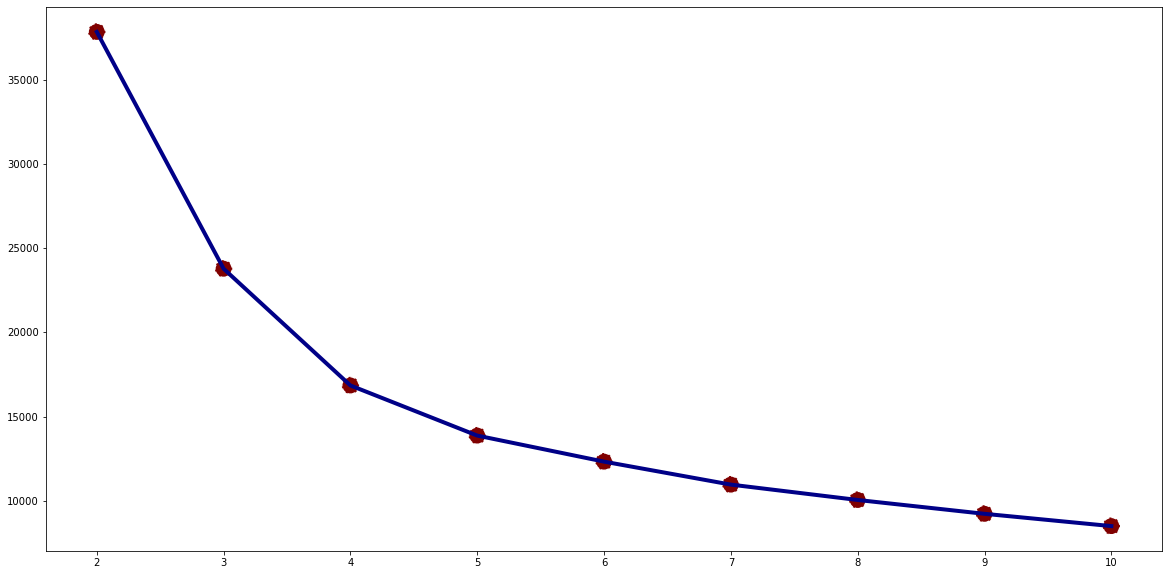

In [61]:
inertia = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df_select_std)
    inertia.append(kmeans.inertia_)



plt.figure(figsize=(20, 10))

sns.lineplot(x=range(2, 11), y=inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2, 11), y=inertia, s=300, color='#800000',  linestyle='--')
plt.show()

- Silhouette score

In [62]:
from sklearn.metrics import silhouette_score

range_n_clusters = list(range(2,11))
arr_silhouette_score_euclidean = []
for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i).fit(df_select_std)
    preds = kmeans.predict(df_select_std)
     
    score_euclidean = silhouette_score(df_select_std, preds, metric='euclidean')
    arr_silhouette_score_euclidean.append(score_euclidean)

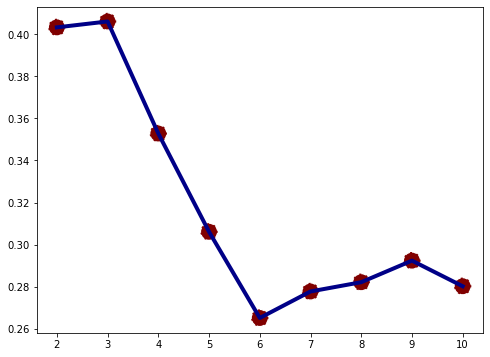

In [63]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(x=range(2,11), y=arr_silhouette_score_euclidean, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2,11), y=arr_silhouette_score_euclidean, s=300, color='#800000',  linestyle='--')
plt.show()

Berdasarkan evaluasi menggunakan Inertia atau Silhouette Score, diperoleh informasi jumlah cluster yang ideal adalah 3 cluster.

- Bikin clusternya

In [64]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_select_std)

In [65]:
clusters = kmeans.labels_

In [66]:
df_clean['clusters'] = clusters

In [67]:
df_clean.sample(5)

MEMBER_NO   FFP_DATE FIRST_FLIGHT_DATE  GENDER  FFP_TIER  WORK_CITY  \
40478      44811 2008-08-08        2008-08-08    Male         4   shanghai   
48043      58941 2011-02-01        2011-02-01    Male         4   hangzhou   
45209       4384 2010-02-22        2010-02-22    Male         4   wuhanshi   
5209        9649 2006-05-13        2006-11-08  Female         4  guangzhou   
23895      53203 2009-07-17        2009-09-18    Male         4       wuxi   

      WORK_PROVINCE WORK_COUNTRY  AGE  LOAD_TIME  ...  LAST_FLIGHT_DATE  \
40478     guangdong           CN   46 2014-03-31  ...        2013-12-22   
48043      zhejiang           CN   36 2014-03-31  ...        2012-08-05   
45209    hubeisheng           CN   47 2014-03-31  ...        2013-05-11   
5209      guangdong           CN   41 2014-03-31  ...        2014-03-26   
23895       jiangsu           CN   32 2014-03-31  ...        2013-09-07   

       LAST_TO_END  AVG_INTERVAL  MAX_INTERVAL  EXCHANGE_COUNT avg_discount  \
40478          101    114.000000           251               1     0.715928   
48043          605     24.000000            57               0     0.716663   
45209          326     65.666667           133               0     0.702182   
5209             6     16.386364           109               2     0.798294   
23895          207     42.454545           130               0     0.705170   

       Points_Sum  Point_NotFlight  MEMBER_DURATION  clusters  
40478        3449                1               67         1  
48043        2866                0               37         1  
45209        2386                0               49         1  
5209        39008               30               94         1  
23895        8838                1               56         1  

[5 rows x 25 columns]

- Analisa Cluster

In [68]:
pca = PCA(n_components=2)

pca.fit(df_select_std)
pcs = pca.transform(df_select_std)

df_pca = pd.DataFrame(data = pcs, columns = ['PC 1', 'PC 2'])
df_pca.head()

PC 1      PC 2
0  1.321474  0.536392
1  2.887532  0.421786
2  2.899975  0.416517
3  2.004123  0.185157
4  1.358869  0.235970

In [69]:
df_pca['clusters'] = clusters
df_pca.head(2)

PC 1      PC 2  clusters
0  1.321474  0.536392         1
1  2.887532  0.421786         2

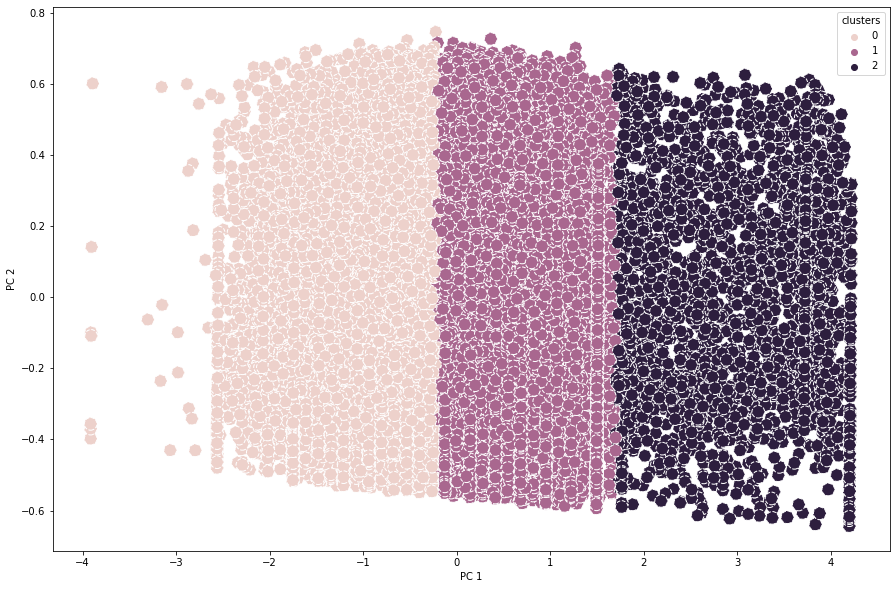

In [70]:
fig, ax = plt.subplots(figsize=(15,10))

sns.scatterplot(
    x='PC 1', y='PC 2',
    hue='clusters',
    linestyle='--',
    data=df_pca,
    s=160,
    ax=ax
)

plt.show()


In [71]:
df_clean[['MEMBER_DURATION', 'LAST_TO_END', 'FLIGHT_COUNT', 'SEG_KM_SUM', 'avg_discount', 'clusters']].groupby('clusters').median()

MEMBER_DURATION  LAST_TO_END  FLIGHT_COUNT  SEG_KM_SUM  avg_discount
clusters                                                                      
0                    39.0        114.0           6.0      9170.0      0.591180
1                    43.0        102.0           8.0     10846.0      0.782434
2                    53.0         78.0           9.0     12898.0      1.275279

In [72]:
df_clean['clusters'].value_counts().to_frame().reset_index().rename(columns={"index": "clusters", "clusters": "total_members"})

clusters  total_members
0         1          33083
1         0          25783
2         2           2570

- Cluster 0 (middle value customer)
- Cluster 1 (low value customer)
- Cluster 2 (high value customers)